In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay


In [2]:
file_paths = {
    "MC": "MC.mat",
    "MADHD": "MADHD.mat",
    "FC": "FC.mat",
    "FADHD": "FADHD.mat"
}

eeg_data = {}
for label, path in file_paths.items():
    data = sio.loadmat(path)
    eeg_data[label] = [data[label][:, i] for i in range(5)]


In [3]:
def extract_features(eeg_segments):
    feature_list = []
    for segment in eeg_segments:
        data = segment[0]
        for i in range(data.shape[0]):
            signal = data[i]
            mean_feats = np.mean(signal, axis=0)
            std_feats = np.std(signal, axis=0)
            features = np.concatenate([mean_feats, std_feats])
            feature_list.append(features)
    return np.array(feature_list)

X = []
y = []

for label, segments in eeg_data.items():
    features = extract_features(segments)
    X.append(features)
    y.extend([1 if "ADHD" in label else 0] * features.shape[0])

X = np.vstack(X)
y = np.array(y)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    }

results_df = pd.DataFrame(results).T.round(4)
results_df


,Accuracy,F1 Score,AUC
Logistic Regression,0.7375,0.6557,0.8528
Random Forest,0.7875,0.7463,0.8559
SVM (RBF Kernel),0.7250,0.6207,0.8672


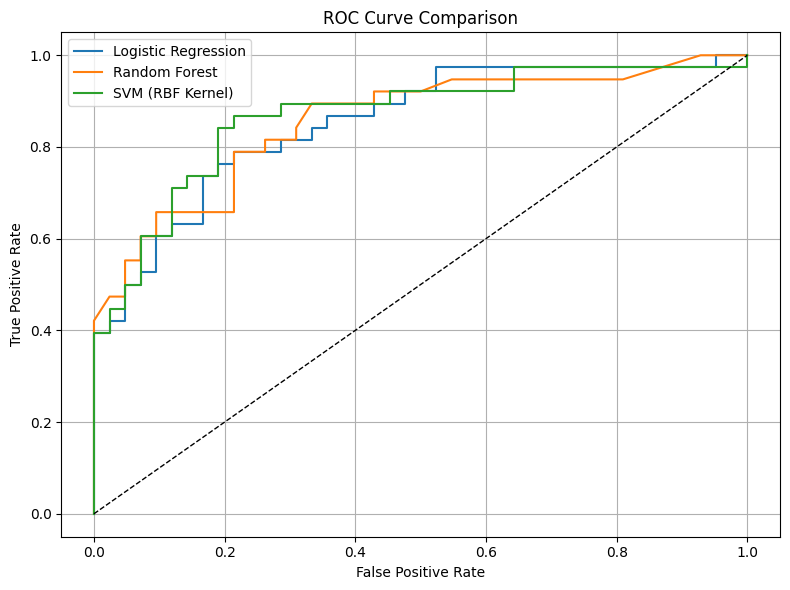

In [5]:
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


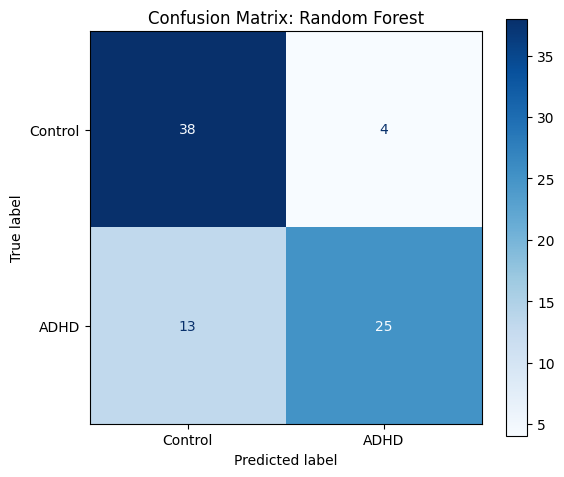

In [6]:
best_model = models['Random Forest']
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Control", "ADHD"])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix: Random Forest")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import classification_report

# Classification report for best model
print("F1 Score Matrix (Classification Report):")
print(classification_report(y_test, y_pred_best, target_names=["Control", "ADHD"]))


F1 Score Matrix (Classification Report):
              precision    recall  f1-score   support

     Control       0.75      0.90      0.82        42
        ADHD       0.86      0.66      0.75        38

    accuracy                           0.79        80
   macro avg       0.80      0.78      0.78        80
weighted avg       0.80      0.79      0.78        80

